In [21]:
import os, datetime, time, re, warnings, gc, json, random, yaml, pickle

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, f1_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import MiniBatchKMeans

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

In [22]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [23]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        for col in use_columns:
            if df[col].dtype.name in ["object", "category"]:
                df[col] = df[col].astype(str)
                le = LabelEncoder().fit(df[col])
                df[col] = le.transform(df[col])+1
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def yeo_johnson(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(df[num_columns])

        df[num_columns] = pt.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def umap_scaler(self, skip_columns=[]):
        self.yeo_johnson(skip_columns=skip_columns)
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]
        for col in num_columns:
            df[col] = df[col].replace(np.inf, np.nan)
            df[col].fillna(-9999, inplace=True)
        
        um = umap.UMAP()
        um.fit(df[num_columns])
        d = um.transform(df[num_columns])
        df["umap_d1"] = d[:, 0]
        df["umap_d2"] = d[:, 1]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def create_kmean_features(self, seed, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        for col in num_columns:
            df[col].fillna(-9999, inplace=True)
        X = df[num_columns]
        
        kmeans = MiniBatchKMeans(n_clusters=10, random_state=seed)
        kmeans.fit(X)

        df["k_class"] = kmeans.predict(X)
        train_distances = kmeans.transform(X)
        for i in range(10):
            df[f"k_distance_{i}"] = train_distances[:, i]
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def min_max_scaling(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        
        scaler = MinMaxScaler()
        scaler.fit(df[num_columns])
        df[num_columns] = scaler.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def two_by_two(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        targets = num_columns.copy()
        for col in num_columns:
            targets.remove(col)
            for t in targets:
                df[f"{col}_{t}_mul"] = df[col] * df[t]
                df[f"{col}_{t}_sub_left"] = df[col] / df[t]
                df[f"{col}_{t}_sub_right"] = df[t] / df[col]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [24]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.__seed_everything(AutoML.SEED)
        self.target = scenario["target"]
        self.engine.load_data()
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)
        
        self.predicts, importance = self.__train(params)
        
    def greedy_forward_selection(self, base_score, base_path="./"):
        self.__seed_everything(AutoML.SEED)
        best_score = 0.0
        selected = set([])
        params = None
        scenario = None
        del self.engine.train, self.engine.test
        with open(f"{base_path}/param_{base_score}.json") as f:
            params = json.load(f)
        with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
            scenario = yaml.safe_load(yml)
        self.target = scenario["target"]
        
        train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
        test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")
        
        train_x = [f for f in train.columns if f not in self.target]
        while True:
            if len(selected) == len(train_x): break
            
            scores = []
            for col in train_x:
                if col not in selected:
                    feats = list(selected) + [col]
                    self.engine.train = train[list(feats)+[self.target]]
                    self.engine.test = test[feats]
                    self.predicts, importance = self.__train(params)
                    param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
                    scores.append((col, param_with_score["score"]))
            
            b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1], reverse=True)[0]
            print(f"b_score: {b_score}")
            print(f"best_score: {best_score}")
            if b_score > best_score:
                selected.add(b_feature)
                best_score = b_score
                print(f'selected:{b_feature}')
                print(f'score:{b_score}')
            else:
                break
        
        print(f'selected features: {selected}')
        with open("selected.pkl", "wb") as fw:
            pickle.dump(selected, fw)
            
    def __do(self, command):
        if command == "fill_numeric_na":
            self.__fill_numeric_na()
        if command == "binning":
            self.__binning()
        if command == "transformation":
            self.__transformation()
        if command == "topic_encoding":
            self.__topic_encoding()
        if command == "umap":
            self.engine.umap_scaler(skip_columns=[self.target])
        if command == "kmean_features":
            self.engine.create_kmean_features(skip_columns=[self.target], seed=AutoML.SEED)
        if command == "min_max_scaling":
            self.engine.min_max_scaling(skip_columns=[self.target])
        if command == "two_by_two":
            self.engine.two_by_two(skip_columns=[self.target])
    
    def __evaluate(self, params, actuals, metric):
        calc_score_param = {"metric": metric}
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
        
        score = self.__calc_score(calc_score_param, actuals[self.target], actuals[AutoML.EVAL_COLUMN])
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        aggs = ["min", "max", "mean", "std"]
        for col in feats:
            if self.engine.train[col].dtype.name == "category":
                self.engine.agg_transform(group=[col], agg={f"{col}": ["count"]})
            for c in num_columns:
                if c == col: continue
                self.engine.agg_transform(group=[col], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{col}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        cat_columns = [col for col in feats if self.engine.train[col].dtype.name == "category"]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train[n].fillna(self.engine.train[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test[n].fillna(self.engine.test[f"_tmp_{n}_mean"], inplace=True)
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()

        for c in num_columns:
            if df[c].unique().shape[0] > 100:
                df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __topic_encoding(self):
        self.__create_topic_text()
        self.engine.calc_topic_score(topic_text_columns=["topic_text"], num_topics=5)
        self.__drop_features(["topic_text"])

    def __create_topic_text(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()
        
        df["topic_text"] = ""
        for c in num_columns:
            df["topic_text"] = df["topic_text"].astype(str) + " " + df[c].astype(str)

        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __set_column_type(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if self.engine.train[col].unique().shape[0] < 20:
                self.engine.train[col] = self.engine.train[col].astype("category")
                self.engine.test[col] = self.engine.test[col].astype("category")

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __feature_selection(self, cols):
        self.engine.train = self.engine.train.loc[:, list(cols)+[self.target]]
        self.engine.test = self.engine.test.loc[:, cols]
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = list(range(0, 38))
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = list(range(0, 38))
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)
        if params["metric"] == "f1":
            return f1_score(actuals, preds)

    def __seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)

In [25]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_pickle("./structure_train_01.pkl")
        self.test = pd.read_pickle("./structure_train_01.pkl")
        
        self.train.columns = range(0, 38)
        self.test.columns = range(0, 38)
        df = pd.read_pickle("./structure_df_01.pkl")
        self.train["k_class"] = df["k_class"]
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        return self

In [26]:
with open("../input/building_structure/scenario.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

In [27]:
ml = AutoML(engine=Sample())

/Users/noguchi/.pyenv/versions/3.6.9/lib/python3.6/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.840828	valid's rmse: 1.43749
[200]	train's rmse: 0.643549	valid's rmse: 1.3875
[300]	train's rmse: 0.541128	valid's rmse: 1.36481
[400]	train's rmse: 0.469407	valid's rmse: 1.34843
[500]	train's rmse: 0.415724	valid's rmse: 1.34937
Early stopping, best iteration is:
[468]	train's rmse: 0.431727	valid's rmse: 1.34311


tune_feature_fraction, val_score: 1.343111:  14%|#4        | 1/7 [00:00<00:03,  1.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.78625	valid's rmse: 1.38709
[200]	train's rmse: 0.584155	valid's rmse: 1.34524
[300]	train's rmse: 0.479024	valid's rmse: 1.32631
[400]	train's rmse: 0.416154	valid's rmse: 1.32233


tune_feature_fraction, val_score: 1.318905:  29%|##8       | 2/7 [00:01<00:03,  1.43it/s]

[500]	train's rmse: 0.370263	valid's rmse: 1.32223
Early stopping, best iteration is:
[483]	train's rmse: 0.377563	valid's rmse: 1.31891
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.744827	valid's rmse: 1.34727
[200]	train's rmse: 0.54219	valid's rmse: 1.30212
[300]	train's rmse: 0.438215	valid's rmse: 1.29107
[400]	train's rmse: 0.37924	valid's rmse: 1.2868
[500]	train's rmse: 0.336097	valid's rmse: 1.29018
Early stopping, best iteration is:
[443]	train's rmse: 0.358718	valid's rmse: 1.28487


tune_feature_fraction, val_score: 1.284872:  43%|####2     | 3/7 [00:02<00:02,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844


tune_feature_fraction, val_score: 1.281388:  57%|#####7    | 4/7 [00:03<00:02,  1.08it/s]

[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


[I 2020-03-24 13:54:22,562] Finished trial#3 resulted in value: 1.2813883921028735. Current best value is 1.2813883921028735 with parameters: {'feature_fraction': 0.7}.
tune_feature_fraction, val_score: 1.281388:  57%|#####7    | 4/7 [00:03<00:02,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.69527	valid's rmse: 1.4052
[200]	train's rmse: 0.501272	valid's rmse: 1.34085
[300]	train's rmse: 0.397727	valid's rmse: 1.30075
[400]	train's rmse: 0.33748	valid's rmse: 1.29081
[500]	train's rmse: 0.299897	valid's rmse: 1.28889
[600]	train's rmse: 0.275037	valid's rmse: 1.28817
[700]	train's rmse: 0.257388	valid's rmse: 1.28839
Early stopping, best iteration is:
[663]	train's rmse: 0.263593	valid's rmse: 1.28716


tune_feature_fraction, val_score: 1.281388:  71%|#######1  | 5/7 [00:05<00:02,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.671021	valid's rmse: 1.36212
[200]	train's rmse: 0.476094	valid's rmse: 1.31703
[300]	train's rmse: 0.376739	valid's rmse: 1.2892
[400]	train's rmse: 0.319017	valid's rmse: 1.28408
Early stopping, best iteration is:
[375]	train's rmse: 0.330303	valid's rmse: 1.28193


tune_feature_fraction, val_score: 1.281388:  86%|########5 | 6/7 [00:06<00:01,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.67137	valid's rmse: 1.32282


tune_feature_fraction, val_score: 1.281388: 100%|##########| 7/7 [00:07<00:00,  1.01it/s]

[200]	train's rmse: 0.477038	valid's rmse: 1.30453
[300]	train's rmse: 0.377769	valid's rmse: 1.29169
[400]	train's rmse: 0.320991	valid's rmse: 1.29364
Early stopping, best iteration is:
[328]	train's rmse: 0.358083	valid's rmse: 1.28973


[I 2020-03-24 13:54:26,010] Finished trial#6 resulted in value: 1.289725108335747. Current best value is 1.2813883921028735 with parameters: {'feature_fraction': 0.7}.
tune_num_leaves, val_score: 1.281388:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.281388:   5%|5         | 1/20 [00:00<00:15,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844


tune_num_leaves, val_score: 1.281388:  10%|#         | 2/20 [00:01<00:14,  1.22it/s]

[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


[I 2020-03-24 13:54:27,720] Finished trial#1 resulted in value: 1.2813883921028735. Current best value is 1.2813883921028735 with parameters: {'num_leaves': 155}.
tune_num_leaves, val_score: 1.281388:  10%|#         | 2/20 [00:01<00:14,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.281388:  15%|#5        | 3/20 [00:02<00:13,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844


tune_num_leaves, val_score: 1.281388:  20%|##        | 4/20 [00:03<00:13,  1.21it/s]

[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


[I 2020-03-24 13:54:29,386] Finished trial#3 resulted in value: 1.2813883921028735. Current best value is 1.2813883921028735 with parameters: {'num_leaves': 155}.
tune_num_leaves, val_score: 1.281388:  20%|##        | 4/20 [00:03<00:13,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.716005	valid's rmse: 1.35427
[200]	train's rmse: 0.50968	valid's rmse: 1.31361
[300]	train's rmse: 0.40913	valid's rmse: 1.29267
[400]	train's rmse: 0.34942	valid's rmse: 1.27951
[500]	train's rmse: 0.308682	valid's rmse: 1.27782


tune_num_leaves, val_score: 1.275692:  25%|##5       | 5/20 [00:04<00:11,  1.28it/s]

Early stopping, best iteration is:
[467]	train's rmse: 0.319666	valid's rmse: 1.27569
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235


tune_num_leaves, val_score: 1.275692:  30%|###       | 6/20 [00:04<00:11,  1.20it/s]

Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608
[400]	train's rmse: 0.402823	valid's rmse: 1.23529
[500]	train's rmse: 0.357473	valid's rmse: 1.23515


tune_num_leaves, val_score: 1.233204:  35%|###5      | 7/20 [00:05<00:09,  1.35it/s]

[600]	train's rmse: 0.324919	valid's rmse: 1.23515
Early stopping, best iteration is:
[511]	train's rmse: 0.352458	valid's rmse: 1.2332
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235


tune_num_leaves, val_score: 1.233204:  40%|####      | 8/20 [00:06<00:09,  1.24it/s]

Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235


tune_num_leaves, val_score: 1.233204:  45%|####5     | 9/20 [00:07<00:09,  1.20it/s]

Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844


tune_num_leaves, val_score: 1.233204:  50%|#####     | 10/20 [00:08<00:08,  1.14it/s]

[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


[I 2020-03-24 13:54:34,367] Finished trial#9 resulted in value: 1.2813883921028735. Current best value is 1.2332035849167224 with parameters: {'num_leaves': 13}.
tune_num_leaves, val_score: 1.233204:  50%|#####     | 10/20 [00:08<00:08,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.233204:  55%|#####5    | 11/20 [00:09<00:08,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.35804	valid's rmse: 1.701
[200]	train's rmse: 1.20393	valid's rmse: 1.61125
[300]	train's rmse: 1.12536	valid's rmse: 1.57784
[400]	train's rmse: 1.07643	valid's rmse: 1.55016
[500]	train's rmse: 1.01954	valid's rmse: 1.48857
[600]	train's rmse: 0.989921	valid's rmse: 1.47292


tune_num_leaves, val_score: 1.233204:  60%|######    | 12/20 [00:09<00:06,  1.31it/s]

[700]	train's rmse: 0.966137	valid's rmse: 1.46389
[800]	train's rmse: 0.938619	valid's rmse: 1.45093
[900]	train's rmse: 0.919288	valid's rmse: 1.44342
[1000]	train's rmse: 0.89793	valid's rmse: 1.42051
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.89793	valid's rmse: 1.42051
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.35804	valid's rmse: 1.701
[200]	train's rmse: 1.20393	valid's rmse: 1.61125
[300]	train's rmse: 1.12536	valid's rmse: 1.57784
[400]	train's rmse: 1.07643	valid's rmse: 1.55016
[500]	train's rmse: 1.01954	valid's rmse: 1.48857
[600]	train's rmse: 0.989921	valid's rmse: 1.47292


tune_num_leaves, val_score: 1.233204:  65%|######5   | 13/20 [00:10<00:04,  1.48it/s]

[700]	train's rmse: 0.966137	valid's rmse: 1.46389
[800]	train's rmse: 0.938619	valid's rmse: 1.45093
[900]	train's rmse: 0.919288	valid's rmse: 1.44342
[1000]	train's rmse: 0.89793	valid's rmse: 1.42051
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.89793	valid's rmse: 1.42051
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235


tune_num_leaves, val_score: 1.233204:  70%|#######   | 14/20 [00:11<00:04,  1.29it/s]

Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.714855	valid's rmse: 1.36357
[200]	train's rmse: 0.522436	valid's rmse: 1.30429
[300]	train's rmse: 0.42219	valid's rmse: 1.28261
[400]	train's rmse: 0.361588	valid's rmse: 1.27888


tune_num_leaves, val_score: 1.233204:  75%|#######5  | 15/20 [00:11<00:03,  1.45it/s]

Early stopping, best iteration is:
[361]	train's rmse: 0.382346	valid's rmse: 1.27482
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235


tune_num_leaves, val_score: 1.233204:  80%|########  | 16/20 [00:12<00:03,  1.29it/s]

Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14661	valid's rmse: 1.55149
[200]	train's rmse: 0.993384	valid's rmse: 1.43999
[300]	train's rmse: 0.906413	valid's rmse: 1.37382
[400]	train's rmse: 0.852016	valid's rmse: 1.34808
[500]	train's rmse: 0.806986	valid's rmse: 1.32101
[600]	train's rmse: 0.768989	valid's rmse: 1.29825
[700]	train's rmse: 0.731337	valid's rmse: 1.28027
[800]	train's rmse: 0.697774	valid's rmse: 1.2591


tune_num_leaves, val_score: 1.233204:  85%|########5 | 17/20 [00:13<00:02,  1.44it/s]

[900]	train's rmse: 0.673914	valid's rmse: 1.25293
[1000]	train's rmse: 0.652759	valid's rmse: 1.24478
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.652759	valid's rmse: 1.24478
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.233204:  90%|######### | 18/20 [00:14<00:01,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.233204:  95%|#########5| 19/20 [00:15<00:00,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.717645	valid's rmse: 1.38432
[200]	train's rmse: 0.517392	valid's rmse: 1.31985
[300]	train's rmse: 0.41676	valid's rmse: 1.2951
[400]	train's rmse: 0.355695	valid's rmse: 1.28678
[500]	train's rmse: 0.314579	valid's rmse: 1.2844
[600]	train's rmse: 0.28891	valid's rmse: 1.28235
Early stopping, best iteration is:
[592]	train's rmse: 0.290248	valid's rmse: 1.28139


tune_num_leaves, val_score: 1.233204: 100%|##########| 20/20 [00:16<00:00,  1.24it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14021	valid's rmse: 1.64909
[200]	train's rmse: 0.973407	valid's rmse: 1.54765
[300]	train's rmse: 0.859502	valid's rmse: 1.52008
[400]	train's rmse: 0.764307	valid's rmse: 1.47699
[500]	train's rmse: 0.686287	valid's rmse: 1.44323


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  10%|#         | 1/10 [00:00<00:05,  1.78it/s][I 2020-03-24 13:54:42,842] Finished trial#0 resulted in value: 1.435463251970977. Current best value is 1.435463251970977 with parameters: {'bagging_fraction': 0.5071550666486464, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  10%|#         | 1/10 [00:00<00:05,  1.78it/s]

[600]	train's rmse: 0.637621	valid's rmse: 1.43877
Early stopping, best iteration is:
[505]	train's rmse: 0.685252	valid's rmse: 1.43546
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.26874	valid's rmse: 1.74715
[200]	train's rmse: 1.08343	valid's rmse: 1.64206
[300]	train's rmse: 0.98726	valid's rmse: 1.60836
[400]	train's rmse: 0.920905	valid's rmse: 1.5473


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  20%|##        | 2/10 [00:01<00:04,  1.69it/s]

[500]	train's rmse: 0.856072	valid's rmse: 1.5107
[600]	train's rmse: 0.812588	valid's rmse: 1.50099
Early stopping, best iteration is:
[561]	train's rmse: 0.827639	valid's rmse: 1.49227


[I 2020-03-24 13:54:43,513] Finished trial#1 resulted in value: 1.4922681369539574. Current best value is 1.435463251970977 with parameters: {'bagging_fraction': 0.5071550666486464, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  20%|##        | 2/10 [00:01<00:04,  1.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.18979	valid's rmse: 1.67416
[200]	train's rmse: 1.02377	valid's rmse: 1.57579
[300]	train's rmse: 0.907227	valid's rmse: 1.54118
[400]	train's rmse: 0.810901	valid's rmse: 1.49447
[500]	train's rmse: 0.741816	valid's rmse: 1.44236


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  30%|###       | 3/10 [00:01<00:04,  1.62it/s][I 2020-03-24 13:54:44,187] Finished trial#2 resulted in value: 1.4358127207108455. Current best value is 1.435463251970977 with parameters: {'bagging_fraction': 0.5071550666486464, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  30%|###       | 3/10 [00:01<00:04,  1.62it/s]

[600]	train's rmse: 0.697594	valid's rmse: 1.4496
Early stopping, best iteration is:
[505]	train's rmse: 0.740767	valid's rmse: 1.43581
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.796086	valid's rmse: 1.38173
[200]	train's rmse: 0.596058	valid's rmse: 1.2863
[300]	train's rmse: 0.493969	valid's rmse: 1.27003
[400]	train's rmse: 0.423114	valid's rmse: 1.26741


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  40%|####      | 4/10 [00:02<00:03,  1.73it/s][I 2020-03-24 13:54:44,672] Finished trial#3 resulted in value: 1.2595822934114822. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  40%|####      | 4/10 [00:02<00:03,  1.73it/s]

[500]	train's rmse: 0.372867	valid's rmse: 1.26483
Early stopping, best iteration is:
[424]	train's rmse: 0.408512	valid's rmse: 1.25958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.13788	valid's rmse: 1.66803
[200]	train's rmse: 0.921076	valid's rmse: 1.53536
[300]	train's rmse: 0.813915	valid's rmse: 1.52309


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  50%|#####     | 5/10 [00:02<00:02,  1.80it/s][I 2020-03-24 13:54:45,177] Finished trial#4 resulted in value: 1.4924259266036815. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  50%|#####     | 5/10 [00:02<00:02,  1.80it/s]

[400]	train's rmse: 0.729942	valid's rmse: 1.50299
Early stopping, best iteration is:
[330]	train's rmse: 0.791202	valid's rmse: 1.49243
Training until validation scores don't improve for 100 rounds


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  60%|######    | 6/10 [00:03<00:02,  1.99it/s]

[100]	train's rmse: 1.03916	valid's rmse: 1.59748
[200]	train's rmse: 0.844201	valid's rmse: 1.51015
[300]	train's rmse: 0.720369	valid's rmse: 1.48515
Early stopping, best iteration is:
[222]	train's rmse: 0.808119	valid's rmse: 1.47944


[I 2020-03-24 13:54:45,557] Finished trial#5 resulted in value: 1.4794385174902123. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  60%|######    | 6/10 [00:03<00:02,  1.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.03849	valid's rmse: 1.60099
[200]	train's rmse: 0.840137	valid's rmse: 1.5051
[300]	train's rmse: 0.718471	valid's rmse: 1.46708
[400]	train's rmse: 0.624914	valid's rmse: 1.46126
[500]	train's rmse: 0.557465	valid's rmse: 1.45617
[600]	train's rmse: 0.510534	valid's rmse: 1.43809


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  70%|#######   | 7/10 [00:03<00:01,  1.75it/s][I 2020-03-24 13:54:46,288] Finished trial#6 resulted in value: 1.428821544144198. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  70%|#######   | 7/10 [00:04<00:01,  1.75it/s]

[700]	train's rmse: 0.469192	valid's rmse: 1.44079
Early stopping, best iteration is:
[686]	train's rmse: 0.473356	valid's rmse: 1.42882
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.865744	valid's rmse: 1.46437
[200]	train's rmse: 0.668563	valid's rmse: 1.39712
[300]	train's rmse: 0.556511	valid's rmse: 1.34948


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  80%|########  | 8/10 [00:04<00:01,  1.84it/s][I 2020-03-24 13:54:46,778] Finished trial#7 resulted in value: 1.325098085963088. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.


[400]	train's rmse: 0.477279	valid's rmse: 1.34286
[500]	train's rmse: 0.421065	valid's rmse: 1.33244
Early stopping, best iteration is:
[468]	train's rmse: 0.437842	valid's rmse: 1.3251


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  80%|########  | 8/10 [00:04<00:01,  1.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.14865	valid's rmse: 1.62891
[200]	train's rmse: 0.96641	valid's rmse: 1.53519
[300]	train's rmse: 0.86287	valid's rmse: 1.52045
[400]	train's rmse: 0.77608	valid's rmse: 1.49478
[500]	train's rmse: 0.71774	valid's rmse: 1.44984


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  90%|######### | 9/10 [00:05<00:00,  1.50it/s][I 2020-03-24 13:54:47,720] Finished trial#8 resulted in value: 1.4455060821402528. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204:  90%|######### | 9/10 [00:05<00:00,  1.50it/s]

[600]	train's rmse: 0.664572	valid's rmse: 1.46625
Early stopping, best iteration is:
[502]	train's rmse: 0.71753	valid's rmse: 1.44551
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.10441	valid's rmse: 1.64775
[200]	train's rmse: 0.899709	valid's rmse: 1.53368
[300]	train's rmse: 0.786922	valid's rmse: 1.51614
[400]	train's rmse: 0.701024	valid's rmse: 1.48334
[500]	train's rmse: 0.627159	valid's rmse: 1.47048
[600]	train's rmse: 0.574212	valid's rmse: 1.45856
[700]	train's rmse: 0.531977	valid's rmse: 1.45151
[800]	train's rmse: 0.494162	valid's rmse: 1.44247
[900]	train's rmse: 0.462042	valid's rmse: 1.44049


tune_bagging_fraction_and_bagging_freq, val_score: 1.233204: 100%|##########| 10/10 [00:06<00:00,  1.28it/s][I 2020-03-24 13:54:48,771] Finished trial#9 resulted in value: 1.4325884832511369. Current best value is 1.2595822934114822 with parameters: {'bagging_fraction': 0.8736983045326786, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 1.233204: 100%|##########| 10/10 [00:06<00:00,  1.52it/s]
tune_feature_fraction, val_score: 1.233204:   0%|          | 0/6 [00:00<?, ?it/s]

[1000]	train's rmse: 0.43527	valid's rmse: 1.43259
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.43527	valid's rmse: 1.43259
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.764471	valid's rmse: 1.36437
[200]	train's rmse: 0.577671	valid's rmse: 1.30294


tune_feature_fraction, val_score: 1.233204:  17%|#6        | 1/6 [00:00<00:02,  2.45it/s]

[300]	train's rmse: 0.47907	valid's rmse: 1.26606
[400]	train's rmse: 0.4144	valid's rmse: 1.2414
[500]	train's rmse: 0.366076	valid's rmse: 1.23705
Early stopping, best iteration is:
[468]	train's rmse: 0.378714	valid's rmse: 1.23615


[I 2020-03-24 13:54:49,274] Finished trial#0 resulted in value: 1.236149274657578. Current best value is 1.236149274657578 with parameters: {'feature_fraction': 0.62}.
tune_feature_fraction, val_score: 1.233204:  17%|#6        | 1/6 [00:00<00:02,  2.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.764471	valid's rmse: 1.36437
[200]	train's rmse: 0.577671	valid's rmse: 1.30294


tune_feature_fraction, val_score: 1.233204:  33%|###3      | 2/6 [00:00<00:01,  2.28it/s]

[300]	train's rmse: 0.47907	valid's rmse: 1.26606
[400]	train's rmse: 0.4144	valid's rmse: 1.2414
[500]	train's rmse: 0.366076	valid's rmse: 1.23705
Early stopping, best iteration is:
[468]	train's rmse: 0.378714	valid's rmse: 1.23615


[I 2020-03-24 13:54:49,783] Finished trial#1 resulted in value: 1.2361492746575777. Current best value is 1.2361492746575777 with parameters: {'feature_fraction': 0.652}.
tune_feature_fraction, val_score: 1.233204:  33%|###3      | 2/6 [00:01<00:01,  2.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608


tune_feature_fraction, val_score: 1.233204:  50%|#####     | 3/6 [00:01<00:01,  2.16it/s]

[400]	train's rmse: 0.402823	valid's rmse: 1.23529
[500]	train's rmse: 0.357473	valid's rmse: 1.23515
[600]	train's rmse: 0.324919	valid's rmse: 1.23515
Early stopping, best iteration is:
[511]	train's rmse: 0.352458	valid's rmse: 1.2332


[I 2020-03-24 13:54:50,299] Finished trial#2 resulted in value: 1.2332035849167224. Current best value is 1.2332035849167224 with parameters: {'feature_fraction': 0.6839999999999999}.
tune_feature_fraction, val_score: 1.233204:  50%|#####     | 3/6 [00:01<00:01,  2.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608
[400]	train's rmse: 0.402823	valid's rmse: 1.23529
[500]	train's rmse: 0.357473	valid's rmse: 1.23515
[600]	train's rmse: 0.324919	valid's rmse: 1.23515
Early stopping, best iteration is:
[511]	train's rmse: 0.352458	valid's rmse: 1.2332


tune_feature_fraction, val_score: 1.233204:  67%|######6   | 4/6 [00:02<00:00,  2.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608


tune_feature_fraction, val_score: 1.233204:  83%|########3 | 5/6 [00:02<00:00,  2.07it/s]

[400]	train's rmse: 0.402823	valid's rmse: 1.23529
[500]	train's rmse: 0.357473	valid's rmse: 1.23515
[600]	train's rmse: 0.324919	valid's rmse: 1.23515
Early stopping, best iteration is:
[511]	train's rmse: 0.352458	valid's rmse: 1.2332


[I 2020-03-24 13:54:51,315] Finished trial#4 resulted in value: 1.2332035849167224. Current best value is 1.2332035849167224 with parameters: {'feature_fraction': 0.6839999999999999}.
tune_feature_fraction, val_score: 1.233204:  83%|########3 | 5/6 [00:02<00:00,  2.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.747998	valid's rmse: 1.39456
[200]	train's rmse: 0.551592	valid's rmse: 1.30786
[300]	train's rmse: 0.445147	valid's rmse: 1.27474


tune_feature_fraction, val_score: 1.233204: 100%|##########| 6/6 [00:02<00:00,  2.01it/s]

[400]	train's rmse: 0.38224	valid's rmse: 1.27125
[500]	train's rmse: 0.340901	valid's rmse: 1.26285
Early stopping, best iteration is:
[489]	train's rmse: 0.344153	valid's rmse: 1.26176


[I 2020-03-24 13:54:51,850] Finished trial#5 resulted in value: 1.2617632675234571. Current best value is 1.2332035849167224 with parameters: {'feature_fraction': 0.6839999999999999}.
tune_feature_fraction, val_score: 1.233204: 100%|##########| 6/6 [00:03<00:00,  1.95it/s]
tune_lambda_l1_and_lambda_l2, val_score: 1.233204:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.744553	valid's rmse: 1.34577
[200]	train's rmse: 0.562517	valid's rmse: 1.28894
[300]	train's rmse: 0.461208	valid's rmse: 1.26102


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:   5%|5         | 1/20 [00:00<00:07,  2.56it/s][I 2020-03-24 13:54:52,338] Finished trial#0 resulted in value: 1.2399063466217632. Current best value is 1.2399063466217632 with parameters: {'lambda_l1': 3.839647652682402e-06, 'lambda_l2': 2.7007259484128036e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.233204:   5%|5         | 1/20 [00:00<00:07,  2.56it/s]

[400]	train's rmse: 0.396358	valid's rmse: 1.24298
[500]	train's rmse: 0.353061	valid's rmse: 1.24158
Early stopping, best iteration is:
[434]	train's rmse: 0.380567	valid's rmse: 1.23991
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.750754	valid's rmse: 1.36699
[200]	train's rmse: 0.567375	valid's rmse: 1.32024
[300]	train's rmse: 0.464335	valid's rmse: 1.2832
[400]	train's rmse: 0.401468	valid's rmse: 1.26456
[500]	train's rmse: 0.355722	valid's rmse: 1.26482
Early stopping, best iteration is:
[416]	train's rmse: 0.392919	valid's rmse: 1.26228


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  10%|#         | 2/20 [00:00<00:07,  2.47it/s][I 2020-03-24 13:54:52,776] Finished trial#1 resulted in value: 1.2622813512074618. Current best value is 1.2399063466217632 with parameters: {'lambda_l1': 3.839647652682402e-06, 'lambda_l2': 2.7007259484128036e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  10%|#         | 2/20 [00:00<00:07,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.739097	valid's rmse: 1.36329
[200]	train's rmse: 0.55784	valid's rmse: 1.30593
[300]	train's rmse: 0.460363	valid's rmse: 1.26887


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  15%|#5        | 3/20 [00:01<00:07,  2.34it/s][I 2020-03-24 13:54:53,255] Finished trial#2 resulted in value: 1.2391551072145601. Current best value is 1.2391551072145601 with parameters: {'lambda_l1': 0.00020662839003372855, 'lambda_l2': 0.1801451761997221}.


[400]	train's rmse: 0.397107	valid's rmse: 1.25263
[500]	train's rmse: 0.35247	valid's rmse: 1.24495
Early stopping, best iteration is:
[472]	train's rmse: 0.36224	valid's rmse: 1.23916


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  15%|#5        | 3/20 [00:01<00:07,  2.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.757554	valid's rmse: 1.36653
[200]	train's rmse: 0.564251	valid's rmse: 1.29833
[300]	train's rmse: 0.467654	valid's rmse: 1.25994


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  20%|##        | 4/20 [00:01<00:07,  2.27it/s][I 2020-03-24 13:54:53,722] Finished trial#3 resulted in value: 1.241305058690631. Current best value is 1.2391551072145601 with parameters: {'lambda_l1': 0.00020662839003372855, 'lambda_l2': 0.1801451761997221}.
tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  20%|##        | 4/20 [00:01<00:07,  2.27it/s]

[400]	train's rmse: 0.402255	valid's rmse: 1.24607
[500]	train's rmse: 0.357952	valid's rmse: 1.24378
Early stopping, best iteration is:
[463]	train's rmse: 0.37218	valid's rmse: 1.24131
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.757553	valid's rmse: 1.36653
[200]	train's rmse: 0.56425	valid's rmse: 1.29833
[300]	train's rmse: 0.467654	valid's rmse: 1.25994


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  25%|##5       | 5/20 [00:02<00:06,  2.15it/s]

[400]	train's rmse: 0.402255	valid's rmse: 1.24607
[500]	train's rmse: 0.357952	valid's rmse: 1.24378
Early stopping, best iteration is:
[463]	train's rmse: 0.37218	valid's rmse: 1.24131


[I 2020-03-24 13:54:54,246] Finished trial#4 resulted in value: 1.2413050790134843. Current best value is 1.2391551072145601 with parameters: {'lambda_l1': 0.00020662839003372855, 'lambda_l2': 0.1801451761997221}.
tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  25%|##5       | 5/20 [00:02<00:06,  2.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754646	valid's rmse: 1.36438
[200]	train's rmse: 0.569384	valid's rmse: 1.31568
[300]	train's rmse: 0.46941	valid's rmse: 1.27446
[400]	train's rmse: 0.409545	valid's rmse: 1.25903
[500]	train's rmse: 0.366521	valid's rmse: 1.25191
[600]	train's rmse: 0.334084	valid's rmse: 1.252
[700]	train's rmse: 0.311332	valid's rmse: 1.24918


tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  30%|###       | 6/20 [00:02<00:07,  1.88it/s][I 2020-03-24 13:54:54,935] Finished trial#5 resulted in value: 1.2487079293448569. Current best value is 1.2391551072145601 with parameters: {'lambda_l1': 0.00020662839003372855, 'lambda_l2': 0.1801451761997221}.
tune_lambda_l1_and_lambda_l2, val_score: 1.233204:  30%|###       | 6/20 [00:03<00:07,  1.88it/s]

[800]	train's rmse: 0.293994	valid's rmse: 1.25191
Early stopping, best iteration is:
[707]	train's rmse: 0.309995	valid's rmse: 1.24871
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.561107	valid's rmse: 1.27865
[300]	train's rmse: 0.462679	valid's rmse: 1.24169
[400]	train's rmse: 0.401197	valid's rmse: 1.23274


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  35%|###5      | 7/20 [00:03<00:07,  1.85it/s][I 2020-03-24 13:54:55,491] Finished trial#6 resulted in value: 1.2238636620069248. Current best value is 1.2238636620069248 with parameters: {'lambda_l1': 1.0889545032564084e-06, 'lambda_l2': 2.0856119619157083e-06}.


[500]	train's rmse: 0.356771	valid's rmse: 1.22516
[600]	train's rmse: 0.325104	valid's rmse: 1.22706
Early stopping, best iteration is:
[508]	train's rmse: 0.353579	valid's rmse: 1.22386


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  35%|###5      | 7/20 [00:03<00:07,  1.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.779927	valid's rmse: 1.40188
[200]	train's rmse: 0.621737	valid's rmse: 1.34473
[300]	train's rmse: 0.538438	valid's rmse: 1.32209


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  40%|####      | 8/20 [00:04<00:06,  1.84it/s]

[400]	train's rmse: 0.485968	valid's rmse: 1.30583
[500]	train's rmse: 0.445665	valid's rmse: 1.30214
[600]	train's rmse: 0.425693	valid's rmse: 1.30085
Early stopping, best iteration is:
[564]	train's rmse: 0.427849	valid's rmse: 1.29955


[I 2020-03-24 13:54:56,054] Finished trial#7 resulted in value: 1.2995521139514852. Current best value is 1.2238636620069248 with parameters: {'lambda_l1': 1.0889545032564084e-06, 'lambda_l2': 2.0856119619157083e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  40%|####      | 8/20 [00:04<00:06,  1.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.788776	valid's rmse: 1.39397
[200]	train's rmse: 0.600806	valid's rmse: 1.33791
[300]	train's rmse: 0.497545	valid's rmse: 1.29516
[400]	train's rmse: 0.432457	valid's rmse: 1.27015
[500]	train's rmse: 0.38181	valid's rmse: 1.26033
[600]	train's rmse: 0.347971	valid's rmse: 1.25795
[700]	train's rmse: 0.322229	valid's rmse: 1.25436
[800]	train's rmse: 0.301431	valid's rmse: 1.25349


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  45%|####5     | 9/20 [00:04<00:06,  1.61it/s]

[900]	train's rmse: 0.28534	valid's rmse: 1.24982
[1000]	train's rmse: 0.272195	valid's rmse: 1.24828
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.272195	valid's rmse: 1.24828


[I 2020-03-24 13:54:56,866] Finished trial#8 resulted in value: 1.2482768636223893. Current best value is 1.2238636620069248 with parameters: {'lambda_l1': 1.0889545032564084e-06, 'lambda_l2': 2.0856119619157083e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  45%|####5     | 9/20 [00:05<00:06,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.561107	valid's rmse: 1.27865
[300]	train's rmse: 0.462679	valid's rmse: 1.24169
[400]	train's rmse: 0.401197	valid's rmse: 1.23274
[500]	train's rmse: 0.356771	valid's rmse: 1.22516
[600]	train's rmse: 0.325118	valid's rmse: 1.22594
Early stopping, best iteration is:
[508]	train's rmse: 0.353579	valid's rmse: 1.22386


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  50%|#####     | 10/20 [00:05<00:06,  1.63it/s][I 2020-03-24 13:54:57,453] Finished trial#9 resulted in value: 1.2238636578325388. Current best value is 1.2238636578325388 with parameters: {'lambda_l1': 5.6146079110789515e-08, 'lambda_l2': 3.427415135437599e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  50%|#####     | 10/20 [00:05<00:06,  1.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  55%|#####5    | 11/20 [00:06<00:05,  1.69it/s]

[400]	train's rmse: 0.402823	valid's rmse: 1.23529
[500]	train's rmse: 0.357473	valid's rmse: 1.23515
[600]	train's rmse: 0.324919	valid's rmse: 1.23515
Early stopping, best iteration is:
[511]	train's rmse: 0.352458	valid's rmse: 1.2332


[I 2020-03-24 13:54:57,987] Finished trial#10 resulted in value: 1.2332035850970597. Current best value is 1.2238636578325388 with parameters: {'lambda_l1': 5.6146079110789515e-08, 'lambda_l2': 3.427415135437599e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  55%|#####5    | 11/20 [00:06<00:05,  1.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  60%|######    | 12/20 [00:06<00:04,  1.77it/s]

[400]	train's rmse: 0.402823	valid's rmse: 1.23529
[500]	train's rmse: 0.357473	valid's rmse: 1.23515
[600]	train's rmse: 0.324919	valid's rmse: 1.23515
Early stopping, best iteration is:
[511]	train's rmse: 0.352458	valid's rmse: 1.2332


[I 2020-03-24 13:54:58,498] Finished trial#11 resulted in value: 1.2332035852013874. Current best value is 1.2238636578325388 with parameters: {'lambda_l1': 5.6146079110789515e-08, 'lambda_l2': 3.427415135437599e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  60%|######    | 12/20 [00:06<00:04,  1.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.757547	valid's rmse: 1.36653
[200]	train's rmse: 0.564244	valid's rmse: 1.29833
[300]	train's rmse: 0.465773	valid's rmse: 1.26706
[400]	train's rmse: 0.401011	valid's rmse: 1.25705
[500]	train's rmse: 0.355385	valid's rmse: 1.24947
[600]	train's rmse: 0.323417	valid's rmse: 1.24669
[700]	train's rmse: 0.299698	valid's rmse: 1.24623
Early stopping, best iteration is:
[638]	train's rmse: 0.313585	valid's rmse: 1.24247


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  65%|######5   | 13/20 [00:07<00:04,  1.74it/s][I 2020-03-24 13:54:59,102] Finished trial#12 resulted in value: 1.2424708639174336. Current best value is 1.2238636578325388 with parameters: {'lambda_l1': 5.6146079110789515e-08, 'lambda_l2': 3.427415135437599e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  65%|######5   | 13/20 [00:07<00:04,  1.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.561107	valid's rmse: 1.27865


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  70%|#######   | 14/20 [00:07<00:03,  1.77it/s]

[300]	train's rmse: 0.462679	valid's rmse: 1.24169
[400]	train's rmse: 0.401197	valid's rmse: 1.23274
[500]	train's rmse: 0.356771	valid's rmse: 1.22516
[600]	train's rmse: 0.325118	valid's rmse: 1.22594
Early stopping, best iteration is:
[508]	train's rmse: 0.353579	valid's rmse: 1.22386


[I 2020-03-24 13:54:59,633] Finished trial#13 resulted in value: 1.2238636560782874. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  70%|#######   | 14/20 [00:07<00:03,  1.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.561107	valid's rmse: 1.27865
[300]	train's rmse: 0.462679	valid's rmse: 1.24169
[400]	train's rmse: 0.401197	valid's rmse: 1.23274
[500]	train's rmse: 0.356771	valid's rmse: 1.22516
[600]	train's rmse: 0.325118	valid's rmse: 1.22594
Early stopping, best iteration is:
[508]	train's rmse: 0.353579	valid's rmse: 1.22386


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  75%|#######5  | 15/20 [00:08<00:02,  1.81it/s][I 2020-03-24 13:55:00,162] Finished trial#14 resulted in value: 1.223863658035248. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  75%|#######5  | 15/20 [00:08<00:02,  1.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754748	valid's rmse: 1.36609
[200]	train's rmse: 0.564177	valid's rmse: 1.29044
[300]	train's rmse: 0.464937	valid's rmse: 1.25282
[400]	train's rmse: 0.401612	valid's rmse: 1.24383
[500]	train's rmse: 0.357265	valid's rmse: 1.23291
[600]	train's rmse: 0.326871	valid's rmse: 1.23002


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  80%|########  | 16/20 [00:08<00:02,  1.72it/s][I 2020-03-24 13:55:00,803] Finished trial#15 resulted in value: 1.2283904144172129. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  80%|########  | 16/20 [00:08<00:02,  1.72it/s]

[700]	train's rmse: 0.30466	valid's rmse: 1.22891
Early stopping, best iteration is:
[648]	train's rmse: 0.315965	valid's rmse: 1.22839
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.757547	valid's rmse: 1.36653
[200]	train's rmse: 0.564244	valid's rmse: 1.29833
[300]	train's rmse: 0.465772	valid's rmse: 1.26706


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  85%|########5 | 17/20 [00:09<00:01,  1.81it/s][I 2020-03-24 13:55:01,293] Finished trial#16 resulted in value: 1.2530789333928387. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  85%|########5 | 17/20 [00:09<00:01,  1.81it/s]

[400]	train's rmse: 0.401885	valid's rmse: 1.25762
[500]	train's rmse: 0.35748	valid's rmse: 1.25531
Early stopping, best iteration is:
[440]	train's rmse: 0.383399	valid's rmse: 1.25308
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.754559	valid's rmse: 1.35355
[200]	train's rmse: 0.560823	valid's rmse: 1.27655
[300]	train's rmse: 0.465161	valid's rmse: 1.24608
[400]	train's rmse: 0.402659	valid's rmse: 1.23909
[500]	train's rmse: 0.356657	valid's rmse: 1.23114
[600]	train's rmse: 0.324432	valid's rmse: 1.23157
Early stopping, best iteration is:
[539]	train's rmse: 0.341573	valid's rmse: 1.23001


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  90%|######### | 18/20 [00:09<00:01,  1.80it/s][I 2020-03-24 13:55:01,857] Finished trial#17 resulted in value: 1.2300101123103993. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  90%|######### | 18/20 [00:10<00:01,  1.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.757548	valid's rmse: 1.36653
[200]	train's rmse: 0.564246	valid's rmse: 1.29833
[300]	train's rmse: 0.464683	valid's rmse: 1.26908
[400]	train's rmse: 0.40089	valid's rmse: 1.25144
[500]	train's rmse: 0.355372	valid's rmse: 1.24504
[600]	train's rmse: 0.323093	valid's rmse: 1.24276


tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  95%|#########5| 19/20 [00:10<00:00,  1.69it/s][I 2020-03-24 13:55:02,530] Finished trial#18 resulted in value: 1.2416689375225332. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864:  95%|#########5| 19/20 [00:10<00:00,  1.69it/s]

[700]	train's rmse: 0.300703	valid's rmse: 1.24376
Early stopping, best iteration is:
[633]	train's rmse: 0.314399	valid's rmse: 1.24167
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.744554	valid's rmse: 1.34577
[200]	train's rmse: 0.562517	valid's rmse: 1.28894
[300]	train's rmse: 0.461208	valid's rmse: 1.26102
[400]	train's rmse: 0.396359	valid's rmse: 1.24298


tune_lambda_l1_and_lambda_l2, val_score: 1.223864: 100%|##########| 20/20 [00:11<00:00,  1.74it/s][I 2020-03-24 13:55:03,064] Finished trial#19 resulted in value: 1.2399062985499654. Current best value is 1.2238636560782874 with parameters: {'lambda_l1': 1.5900933084631792e-07, 'lambda_l2': 1.0321387512426268e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 1.223864: 100%|##########| 20/20 [00:11<00:00,  1.78it/s]
tune_min_child_samples, val_score: 1.223864:   0%|          | 0/5 [00:00<?, ?it/s]

[500]	train's rmse: 0.353062	valid's rmse: 1.24158
Early stopping, best iteration is:
[434]	train's rmse: 0.380567	valid's rmse: 1.23991
Training until validation scores don't improve for 100 rounds


tune_min_child_samples, val_score: 1.081522:  20%|##        | 1/5 [00:00<00:00,  5.63it/s]

[100]	train's rmse: 0.315435	valid's rmse: 1.08996
Early stopping, best iteration is:
[62]	train's rmse: 0.422631	valid's rmse: 1.08152
Training until validation scores don't improve for 100 rounds


tune_min_child_samples, val_score: 1.056777:  40%|####      | 2/5 [00:00<00:00,  4.45it/s][I 2020-03-24 13:55:03,667] Finished trial#1 resulted in value: 1.0567770067675997. Current best value is 1.0567770067675997 with parameters: {'min_child_samples': 10}.


[100]	train's rmse: 0.508848	valid's rmse: 1.0943
[200]	train's rmse: 0.355113	valid's rmse: 1.0633
[300]	train's rmse: 0.272712	valid's rmse: 1.05973
Early stopping, best iteration is:
[260]	train's rmse: 0.300264	valid's rmse: 1.05678


tune_min_child_samples, val_score: 1.056777:  40%|####      | 2/5 [00:00<00:00,  4.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.86532	valid's rmse: 1.4922
[200]	train's rmse: 0.669659	valid's rmse: 1.4243
[300]	train's rmse: 0.549775	valid's rmse: 1.37912
[400]	train's rmse: 0.472949	valid's rmse: 1.35911
[500]	train's rmse: 0.418548	valid's rmse: 1.34986
[600]	train's rmse: 0.380557	valid's rmse: 1.34905
[700]	train's rmse: 0.353767	valid's rmse: 1.35021
Early stopping, best iteration is:
[649]	train's rmse: 0.367378	valid's rmse: 1.34752


tune_min_child_samples, val_score: 1.056777:  60%|######    | 3/5 [00:01<00:00,  2.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.35014	valid's rmse: 1.80619
[200]	train's rmse: 1.20426	valid's rmse: 1.70729
[300]	train's rmse: 1.08274	valid's rmse: 1.64065
[400]	train's rmse: 0.995132	valid's rmse: 1.58098
[500]	train's rmse: 0.923945	valid's rmse: 1.53432
[600]	train's rmse: 0.869136	valid's rmse: 1.50418
[700]	train's rmse: 0.822957	valid's rmse: 1.48174
[800]	train's rmse: 0.784505	valid's rmse: 1.46025
[900]	train's rmse: 0.751576	valid's rmse: 1.44726
[1000]	train's rmse: 0.723918	valid's rmse: 1.44217
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.723918	valid's rmse: 1.44217


tune_min_child_samples, val_score: 1.056777:  80%|########  | 4/5 [00:02<00:00,  1.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.84389	valid's rmse: 2.00994


tune_min_child_samples, val_score: 1.056777: 100%|##########| 5/5 [00:02<00:00,  2.02it/s]

Early stopping, best iteration is:
[40]	train's rmse: 1.95408	valid's rmse: 1.99008
Training until validation scores don't improve for 100 rounds


[100]	train's rmse: 0.405513	valid's rmse: 1.00767
[200]	train's rmse: 0.265	valid's rmse: 0.969726
[300]	train's rmse: 0.2005	valid's rmse: 0.951149
[400]	train's rmse: 0.161677	valid's rmse: 0.946218
[500]	train's rmse: 0.132237	valid's rmse: 0.942191
[600]	train's rmse: 0.110322	valid's rmse: 0.939833
[700]	train's rmse: 0.0937357	valid's rmse: 0.936926
[800]	train's rmse: 0.0805643	valid's rmse: 0.935438
[900]	train's rmse: 0.0707018	valid's rmse: 0.934616
[1000]	train's rmse: 0.0615551	valid's rmse: 0.934382
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 0.0615551	valid's rmse: 0.934382
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.443973	valid's rmse: 0.884163
[200]	train's rmse: 0.307093	valid's rmse: 0.834893
[300]	train's rmse: 0.232273	valid's rmse: 0.820357
[400]	train's rmse: 0.184382	valid's rmse: 0.816332
[500]	train's rmse: 0.152105	valid's rmse: 0.808029
[600]	train's rmse: 0.126569	valid's rmse: 0.802485
[700]

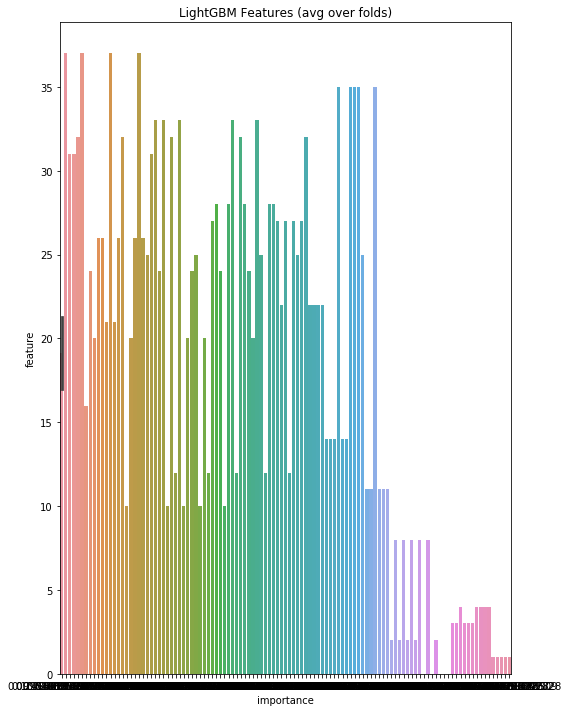

In [28]:
ml.run(scenario)

In [29]:
ml.engine.train.shape

(837, 39)

In [17]:
ml.engine.train["pred"] = ml.predicts.round().astype(int)
ml.engine.train[ml.engine.train["k_class"] != ml.engine.train["pred"]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,k_class,pred
0,0.227064,-0.531081,-0.108556,1.021981,0.295825,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9,8
8,-0.009059,1.423867,-0.108556,-0.325103,-0.449974,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,6
16,-0.089850,0.008215,-0.108556,1.021981,-0.263525,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
17,-0.325170,1.760927,-0.735186,-0.325103,-0.449974,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7,6
24,1.876043,-0.194021,-0.108556,-0.325103,-0.263525,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,5
33,-0.521549,1.221631,-0.108556,-0.325103,-0.449974,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,6
36,-0.518927,1.289043,-0.108556,-0.325103,-0.636424,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,6
43,-0.518383,1.356455,-0.108556,-0.325103,-0.449974,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,6
60,-0.413248,-0.598493,-0.108556,1.021981,-0.263525,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
64,-0.392978,-0.868141,-0.108556,-0.325103,1.041624,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:
ml.engine.train[ml.engine.train["k_class"] != ml.engine.train["pred"]].shape

(113, 40)

In [20]:
1.0 - (113.0/837.0)

0.8649940262843488

In [ ]:
actual = pd.read_csv("../input/vortex/vortex_actual_05.csv")
actual["pred"] = ml.predicts
actual.to_csv("actual_05.csv")

In [ ]:
with open("selected.pkl", "rb") as f:
    hoge = pickle.load(f)

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
df = pd.concat([train, test])

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(train[["Age", "Fare"]])

train[["Age", "Fare"]] = scaler.transform(train[["Age", "Fare"]])
train["Age"].fillna(-9999, inplace=True)
train["Fare"].fillna(-9999, inplace=True)

In [ ]:
import umap

um = umap.UMAP()
um.fit(train[["Age", "Fare"]])

d = um.transform(train[["Age", "Fare"]])

In [ ]:
d[:, 1]

In [ ]:
train.head()

In [ ]:
train[["Age", "Fare"]] = train[["Age", "Fare"]].replace(np.inf, np.nan)

In [ ]:
df = pd.concat([ml.engine.train, ml.engine.test], ignore_index=True)
skip_columns = ["Survived"]

In [ ]:
feats = [f for f in df.columns if f not in skip_columns]
num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]

In [ ]:
num_columns

In [ ]:
for col in num_columns:
    df[col] = df[col].replace(np.inf, np.nan)
    df[col].fillna(-9999, inplace=True)

In [ ]:
um = umap.UMAP()
um.fit(df[num_columns])
df[num_columns] = um.transform(df[num_columns])

In [ ]:
df[num_columns].shape

In [ ]:
um.transform(df[num_columns])

In [ ]:
base_path = "./"
base_score = 0.7681353456669913

In [ ]:
best_score = 0.0
selected = set([])
params = None
scenario = None
with open(f"{base_path}/param_{base_score}.json") as f:
    params = json.load(f)
with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")

train_x = [f for f in train.columns if f not in ["Survived"]]

In [ ]:
scores = []
for col in train_x:
    if col not in selected:
        feats = list(selected) + [col]
        param_with_score = 1
        scores.append((col, param_with_score))

In [ ]:
b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1])[0]
if b_score > best_score:
    selected.add(b_feature)
    best_score = b_score
    print(f'selected:{b_feature}')
    print(f'score:{b_score}')
else:
    break